In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor

In [3]:
# Load the dataset
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [8]:
# Show unique values in the 'Category' column
print(data['Category'].unique())


['Protein' 'Vitamin' 'Omega' 'Performance' 'Amino Acid' 'Mineral' 'Herbal'
 'Sleep Aid' 'Fat Burner' 'Hydration']


In [10]:
# Show unique values in the 'Category' column
print(data['Location'].unique())


['Canada' 'UK' 'USA']


In [12]:
print(data['Platform'] == "Amazon" )

0       False
1        True
2        True
3       False
4       False
        ...  
4379    False
4380    False
4381    False
4382     True
4383    False
Name: Platform, Length: 4384, dtype: bool


# PlatFrom Amazon

In [24]:
amazon = data[data['Platform'] == "Amazon"]

In [26]:
amazon.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
7,2020-01-06,Zinc,Mineral,147,46.68,6861.96,0.19,0,Canada,Amazon
8,2020-01-06,Collagen Peptides,Protein,147,10.96,1611.12,0.06,2,USA,Amazon
9,2020-01-06,Magnesium,Mineral,134,20.76,2781.84,0.00,0,Canada,Amazon


In [28]:
# Make a copy of the DataFrame (especially if it's a slice)
amazon_df = amazon.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df['Year'] = amazon_df['Date'].dt.year
amazon_df['Month'] = amazon_df['Date'].dt.month

# Now it's safe to drop 'Date'
amazon_df = amazon_df.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = amazon_df[features]
y = amazon_df[target]


In [30]:
amazon_df.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
1,Vitamin,42.51,5908.89,0.04,0,UK,Amazon,2020,1
2,Omega,12.91,2078.51,0.25,0,Canada,Amazon,2020,1
7,Mineral,46.68,6861.96,0.19,0,Canada,Amazon,2020,1
8,Protein,10.96,1611.12,0.06,2,USA,Amazon,2020,1
9,Mineral,20.76,2781.84,0.00,0,Canada,Amazon,2020,1


In [32]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [34]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 215048.6924, R²: 0.9558


# UK Amazon

In [38]:
amazon_uk_df = amazon_df[(amazon_df['Platform'] == 'Amazon') & (amazon_df['Location'] == 'UK')]
amazon_uk_df.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
1,Vitamin,42.51,5908.89,0.04,0,UK,Amazon,2020,1
16,Protein,12.08,1812.00,0.02,2,UK,Amazon,2020,1
25,Mineral,40.65,6016.20,0.24,1,UK,Amazon,2020,1
37,Amino Acid,17.44,2528.80,0.08,3,UK,Amazon,2020,1
48,Protein,26.73,3662.01,0.01,0,UK,Amazon,2020,1


In [44]:

# Now make a copy
amazon_uk_df_copy = amazon_uk_df.copy()

# # # Convert Date to datetime and extract year and month
# # amazon_uk_df_copy['Date'] = pd.to_datetime(amazon_uk_df_copy['Date'])
# # amazon_uk_df_copy['Year'] = amazon_uk_df_copy['Date'].dt.year
# # amazon_uk_df_copy['Month'] = amazon_uk_df_copy['Date'].dt.month

# # Now drop unnecessary columns
# amazon_uk_df_copy = amazon_uk_df_copy.drop(columns=['Product Name', , 'Units Sold'])

# # Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = amazon_uk_df_copy[features]
y = amazon_uk_df_copy[target]

In [46]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [48]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 196048.7209, R²: 0.9621


# USA Amazon

In [51]:
amazon_usa_df = amazon_df[(amazon_df['Platform'] == 'Amazon') & (amazon_df['Location'] == 'USA')]
amazon_usa_df.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
8,Protein,10.96,1611.12,0.06,2,USA,Amazon,2020,1
10,Herbal,15.49,2803.69,0.14,1,USA,Amazon,2020,1
15,Hydration,35.92,5531.68,0.04,2,USA,Amazon,2020,1
17,Vitamin,10.61,1358.08,0.24,2,USA,Amazon,2020,1
19,Vitamin,14.92,2044.04,0.17,2,USA,Amazon,2020,1


In [53]:
amazon_usa_df_copy = amazon_usa_df.copy()
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = amazon_usa_df_copy[features]
y = amazon_usa_df_copy[target]

In [55]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [57]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 213286.5866, R²: 0.9595


# Canada Amazon

In [62]:
amazon_canada_df = amazon_df[(amazon_df['Platform'] == 'Amazon') & (amazon_df['Location'] == 'Canada')]
amazon_canada_df.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
2,Omega,12.91,2078.51,0.25,0,Canada,Amazon,2020,1
7,Mineral,46.68,6861.96,0.19,0,Canada,Amazon,2020,1
9,Mineral,20.76,2781.84,0.00,0,Canada,Amazon,2020,1
21,Amino Acid,29.10,4656.00,0.05,0,Canada,Amazon,2020,1
41,Mineral,38.07,4796.82,0.14,1,Canada,Amazon,2020,1


In [64]:
amazon_canada_df_copy = amazon_usa_df.copy()
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = amazon_canada_df_copy[features]
y = amazon_canada_df_copy[target]

In [66]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [68]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 213286.5866, R²: 0.9595


# UK Walmart


In [72]:
data_uk_wal = data[(data['Platform'] == 'Walmart') & (data['Location'] == 'UK')]
data_uk_wal.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
5,2020-01-06,BCAA,Amino Acid,154,41.19,6343.26,0.13,1,UK,Walmart
6,2020-01-06,Creatine,Performance,134,32.49,4353.66,0.05,1,UK,Walmart
13,2020-01-06,Green Tea Extract,Fat Burner,143,31.88,4558.84,0.06,3,UK,Walmart
22,2020-01-13,Creatine,Performance,154,42.20,6498.80,0.13,0,UK,Walmart
26,2020-01-13,Ashwagandha,Herbal,133,54.35,7228.55,0.16,1,UK,Walmart


In [74]:
# Make a copy of the DataFrame (especially if it's a slice)
data_uk_wal_copy = data_uk_wal.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_uk_wal_copy['Date'] = pd.to_datetime(data_uk_wal_copy['Date'])
data_uk_wal_copy['Year'] = data_uk_wal_copy['Date'].dt.year
data_uk_wal_copy['Month'] = data_uk_wal_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_uk_wal_copy = data_uk_wal_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_uk_wal_copy[features]
y = data_uk_wal_copy[target]


In [76]:
data_uk_wal_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
5,Amino Acid,41.19,6343.26,0.13,1,UK,Walmart,2020,1
6,Performance,32.49,4353.66,0.05,1,UK,Walmart,2020,1
13,Fat Burner,31.88,4558.84,0.06,3,UK,Walmart,2020,1
22,Performance,42.20,6498.80,0.13,0,UK,Walmart,2020,1
26,Herbal,54.35,7228.55,0.16,1,UK,Walmart,2020,1


In [78]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [80]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 149756.2531, R²: 0.9676


# Walmart USA

In [83]:
data_usa_wal = data[(data['Platform'] == 'Walmart') & (data['Location'] == 'USA')]
data_usa_wal.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
11,2020-01-06,Melatonin,Sleep Aid,164,34.41,5643.24,0.04,1,USA,Walmart
18,2020-01-13,Fish Oil,Omega,145,27.49,3986.05,0.19,2,USA,Walmart
29,2020-01-13,Green Tea Extract,Fat Burner,174,18.24,3173.76,0.03,2,USA,Walmart
32,2020-01-20,Whey Protein,Protein,157,41.81,6564.17,0.19,0,USA,Walmart
34,2020-01-20,Fish Oil,Omega,131,50.00,6550.00,0.05,1,USA,Walmart


In [85]:
# Make a copy of the DataFrame (especially if it's a slice)
data_usa_wal_copy = data_usa_wal.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_usa_wal_copy['Date'] = pd.to_datetime(data_usa_wal_copy['Date'])
data_usa_wal_copy['Year'] = data_usa_wal_copy['Date'].dt.year
data_usa_wal_copy['Month'] = data_usa_wal_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_usa_wal_copy = data_usa_wal_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_usa_wal_copy[features]
y = data_usa_wal_copy[target]

In [87]:
data_usa_wal_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
11,Sleep Aid,34.41,5643.24,0.04,1,USA,Walmart,2020,1
18,Omega,27.49,3986.05,0.19,2,USA,Walmart,2020,1
29,Fat Burner,18.24,3173.76,0.03,2,USA,Walmart,2020,1
32,Protein,41.81,6564.17,0.19,0,USA,Walmart,2020,1
34,Omega,50.00,6550.00,0.05,1,USA,Walmart,2020,1


In [89]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [91]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 214474.2287, R²: 0.9546


# Walmart Canada

In [94]:
data_canada_wal = data[(data['Platform'] == 'Walmart') & (data['Location'] == 'Canada')]
data_canada_wal.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
56,2020-01-27,Collagen Peptides,Protein,126,11.68,1471.68,0.02,3,Canada,Walmart
98,2020-02-17,Fish Oil,Omega,129,49.73,6415.17,0.01,1,Canada,Walmart
104,2020-02-17,Collagen Peptides,Protein,132,34.38,4538.16,0.16,3,Canada,Walmart


In [96]:
# Make a copy of the DataFrame (especially if it's a slice)
data_canada_wal_copy = data_canada_wal.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_canada_wal_copy['Date'] = pd.to_datetime(data_canada_wal_copy['Date'])
data_canada_wal_copy['Year'] = data_canada_wal_copy['Date'].dt.year
data_canada_wal_copy['Month'] = data_canada_wal_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_canada_wal_copy = data_canada_wal_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_canada_wal_copy[features]
y = data_canada_wal_copy[target]
data_canada_wal_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
0,Protein,31.98,4573.14,0.03,2,Canada,Walmart,2020,1
3,Vitamin,16.07,2249.80,0.08,0,Canada,Walmart,2020,1
56,Protein,11.68,1471.68,0.02,3,Canada,Walmart,2020,1
98,Omega,49.73,6415.17,0.01,1,Canada,Walmart,2020,2
104,Protein,34.38,4538.16,0.16,3,Canada,Walmart,2020,2


In [98]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [100]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 290998.3880, R²: 0.9409


# iHerb UK

In [103]:
data_uk_iherb = data[(data['Platform'] == 'iHerb') & (data['Location'] == 'UK')]
data_uk_iherb.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
12,2020-01-06,Biotin,Vitamin,159,28.79,4577.61,0.10,1,UK,iHerb
38,2020-01-20,Creatine,Performance,148,54.31,8037.88,0.15,1,UK,iHerb
46,2020-01-20,Iron Supplement,Mineral,155,41.81,6480.55,0.20,0,UK,iHerb
49,2020-01-27,Vitamin C,Vitamin,163,35.90,5851.70,0.07,4,UK,iHerb
51,2020-01-27,Multivitamin,Vitamin,162,34.15,5532.30,0.03,0,UK,iHerb


In [105]:
# Make a copy of the DataFrame (especially if it's a slice)
data_uk_iherb_copy = data_uk_iherb.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_uk_iherb_copy['Date'] = pd.to_datetime(data_uk_iherb_copy['Date'])
data_uk_iherb_copy['Year'] = data_uk_iherb_copy['Date'].dt.year
data_uk_iherb_copy['Month'] = data_uk_iherb_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_uk_iherb_copy = data_uk_iherb_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_uk_iherb_copy[features]
y = data_uk_iherb_copy[target]
data_uk_iherb_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
12,Vitamin,28.79,4577.61,0.10,1,UK,iHerb,2020,1
38,Performance,54.31,8037.88,0.15,1,UK,iHerb,2020,1
46,Mineral,41.81,6480.55,0.20,0,UK,iHerb,2020,1
49,Vitamin,35.90,5851.70,0.07,4,UK,iHerb,2020,1
51,Vitamin,34.15,5532.30,0.03,0,UK,iHerb,2020,1


In [107]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [109]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 207469.7804, R²: 0.9563


# USA iHerb

In [112]:
data_usa_iherb = data[(data['Platform'] == 'iHerb') & (data['Location'] == 'USA')]
data_usa_iherb.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
28,2020-01-13,Biotin,Vitamin,161,18.87,3038.07,0.14,5,USA,iHerb
36,2020-01-20,Pre-Workout,Performance,152,48.05,7303.60,0.01,2,USA,iHerb
39,2020-01-20,Zinc,Mineral,147,10.16,1493.52,0.15,1,USA,iHerb
52,2020-01-27,Pre-Workout,Performance,158,31.84,5030.72,0.18,2,USA,iHerb
53,2020-01-27,BCAA,Amino Acid,136,16.77,2280.72,0.19,2,USA,iHerb


In [114]:
# Make a copy of the DataFrame (especially if it's a slice)
data_usa_iherb_copy = data_usa_iherb.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_usa_iherb_copy['Date'] = pd.to_datetime(data_usa_iherb_copy['Date'])
data_usa_iherb_copy['Year'] = data_usa_iherb_copy['Date'].dt.year
data_usa_iherb_copy['Month'] = data_usa_iherb_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_usa_iherb_copy = data_usa_iherb_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_usa_iherb_copy[features]
y = data_usa_iherb_copy[target]
data_usa_iherb_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
28,Vitamin,18.87,3038.07,0.14,5,USA,iHerb,2020,1
36,Performance,48.05,7303.60,0.01,2,USA,iHerb,2020,1
39,Mineral,10.16,1493.52,0.15,1,USA,iHerb,2020,1
52,Performance,31.84,5030.72,0.18,2,USA,iHerb,2020,1
53,Amino Acid,16.77,2280.72,0.19,2,USA,iHerb,2020,1


In [116]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [118]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 150166.0670, R²: 0.9660


# Canada iHerb

In [121]:
data_canada_iherb = data[(data['Platform'] == 'iHerb') & (data['Location'] == 'Canada')]
data_canada_iherb.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb
14,2020-01-06,Iron Supplement,Mineral,149,42.97,6402.53,0.22,2,Canada,iHerb
20,2020-01-13,Pre-Workout,Performance,141,14.11,1989.51,0.24,1,Canada,iHerb
24,2020-01-13,Collagen Peptides,Protein,134,56.40,7557.60,0.06,1,Canada,iHerb
42,2020-01-20,Ashwagandha,Herbal,156,23.49,3664.44,0.21,1,Canada,iHerb


In [123]:
# Make a copy of the DataFrame (especially if it's a slice)
data_canada_iherb_copy = data_canada_iherb.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
data_canada_iherb_copy['Date'] = pd.to_datetime(data_canada_iherb_copy['Date'])
data_canada_iherb_copy['Year'] = data_canada_iherb_copy['Date'].dt.year
data_canada_iherb_copy['Month'] = data_canada_iherb_copy['Date'].dt.month

# Now it's safe to drop 'Date'
data_canada_iherb_copy = data_canada_iherb_copy.drop(columns=['Product Name', 'Date', 'Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data_canada_iherb_copy[features]
y = data_canada_iherb_copy[target]
data_canada_iherb_copy.head()

,Category,Price,Revenue,Discount,Units Returned,Location,Platform,Year,Month
4,Performance,35.47,5568.79,0.25,3,Canada,iHerb,2020,1
14,Mineral,42.97,6402.53,0.22,2,Canada,iHerb,2020,1
20,Performance,14.11,1989.51,0.24,1,Canada,iHerb,2020,1
24,Protein,56.40,7557.60,0.06,1,Canada,iHerb,2020,1
42,Herbal,23.49,3664.44,0.21,1,Canada,iHerb,2020,1


In [125]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [127]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 205789.1415, R²: 0.9584


# Test multiple Model

In [12]:
# Extract year and month from Date
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Drop unnecessary columns
data = data.drop(columns=['Product Name', 'Date','Units Sold'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category', 'Location', 'Platform']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = data[features]
y = data[target]

In [14]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [16]:
print(feature_names)

['Price', 'Discount', 'Units Returned', 'Year', 'Month', 'Category_Fat Burner', 'Category_Herbal', 'Category_Hydration', 'Category_Mineral', 'Category_Omega', 'Category_Performance', 'Category_Protein', 'Category_Sleep Aid', 'Category_Vitamin', 'Location_UK', 'Location_USA', 'Platform_Walmart', 'Platform_iHerb']


In [18]:
# Initialize base linear regression model
base_lr = LinearRegression()
base_lr.fit(X_train,y_train)

y_pred_lr = base_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f" Base LR - MSE: {mse_lr:.2f}, R²: {r2_lr:.4f}")



 Base LR - MSE: 216989.26, R²: 0.9530


In [20]:
# Initialize ensemble models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

voting_model = VotingRegressor(estimators=[
    ('base_lr', base_lr),
    ('ridge', ridge),
    ('lasso', lasso)
])

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

mse_voting = mean_squared_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print(f"📊 Voting Regressor - MSE: {mse_voting:.2f}, R²: {r2_voting:.4f}")


📊 Voting Regressor - MSE: 216955.93, R²: 0.9530


In [24]:
#Stacking Model
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]
# Define meta-model
meta_model = LinearRegression()
# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test,y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')

Mean Squared Error: 217279.0918, R²: 0.9530


In [26]:
# ----- Bagging Regressor -----
bagging_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=10,
    max_samples=0.8,
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print(f"📦 Bagging Regressor - MSE: {mse_bagging:.2f}, R²: {r2_bagging:.4f}")

📦 Bagging Regressor - MSE: 217601.45, R²: 0.9529


In [28]:
# AdaBoost using LinearRegression as weak learner
ada_lin = AdaBoostRegressor(
    estimator=LinearRegression(),
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)

ada_lin.fit(X_train, y_train)
y_pred_ada_lin = ada_lin.predict(X_test)

# Evaluate
mse_ada_lin = mean_squared_error(y_test, y_pred_ada_lin)
r2_ada_lin = r2_score(y_test, y_pred_ada_lin)

print(f"⚡ AdaBoost (Linear Regression base) - MSE: {mse_ada_lin:.2f}, R²: {r2_ada_lin:.4f}")

⚡ AdaBoost (Linear Regression base) - MSE: 219220.52, R²: 0.9525


In [30]:
# Evaluate models
models = {
    'Linear Regression': y_pred_lr,
    'Bagging': y_pred_bagging,
    'AdaBoost': y_pred_ada_lin,
    'Voting': y_pred_voting
}
r2_scores = {}
for name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores[name] = r2
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  R² Score: {r2:.2f}")

# --- Generate Data for Figures ---


Linear Regression:
  Mean Squared Error: 216989.26
  R² Score: 0.95
Bagging:
  Mean Squared Error: 217601.45
  R² Score: 0.95
AdaBoost:
  Mean Squared Error: 219220.52
  R² Score: 0.95
Voting:
  Mean Squared Error: 216955.93
  R² Score: 0.95


In [32]:
dt_model = DecisionTreeRegressor(random_state=42)
# dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Combine into ensemble
ensemble_model = VotingRegressor(estimators=[
    ('base_lr', base_lr),
    ('dt', dt_model)
])

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble_model.predict(X_test)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Print metrics
print("Ensemble Model Performance:")
print("MSE:", mse_ensemble)
print("R² Score:", r2_ensemble)

Ensemble Model Performance:
MSE: 278854.26039778005
R² Score: 0.9396326435206596


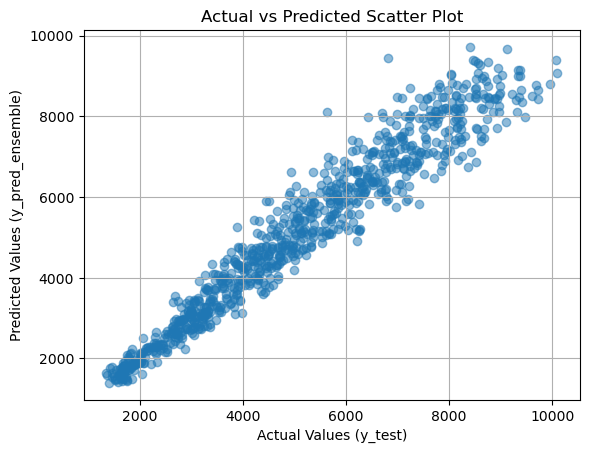

In [34]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_ensemble, alpha=0.5)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred_ensemble)')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.show()